URL del dataset:

https://www.kaggle.com/christianlillelund/csgo-round-winner-classification
    

Aclaracion: Cada una de las observaciones del dataset, describe el estado de una ronda y por lo tanto pueden tratarse individualmente. Aunque se pueden haber tomado distintas observaciones que pertenecen a la misma ronda.


In [61]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score, f1_score

from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier 
from lightgbm import plot_importance

from lime.lime_tabular import LimeTabularExplainer


pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
# Importamos los datos

data = pd.read_csv('Data/cs_go_grupo5.csv', index_col='Unnamed: 0')

df = data.copy()

In [3]:
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


# EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121054 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     121054 non-null  float64
 1   ct_score                      121054 non-null  float64
 2   t_score                       121054 non-null  float64
 3   map                           121054 non-null  object 
 4   bomb_planted                  121054 non-null  bool   
 5   ct_health                     121054 non-null  float64
 6   t_health                      121054 non-null  float64
 7   ct_armor                      121054 non-null  float64
 8   t_armor                       121054 non-null  float64
 9   ct_money                      121054 non-null  float64
 10  t_money                       121054 non-null  float64
 11  ct_helmets                    121054 non-null  float64
 12  t_helmets                     121054 non-nul

In [5]:
# Chequeamos si hay datos faltantes

df.isnull().any().any()

False

In [6]:
df.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.00000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.00000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.0,121054.00000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000
mean,97.779809,6.697152,6.768888,412.612892,403.256034,316.213632,300.425488,9835.801378,11299.019446,2.065822,2.790845,1.621863,4.278677,4.271482,0.275356,1.251442,0.135320,0.007592,0.576420,0.322154,0.0,0.000083,0.152618,0.106308,0.00399,0.001727,0.110835,0.004725,0.0,0.000801,0.011136,0.111017,0.006386,3.313620,0.000008,0.0,0.064203,0.002718,1.082872,0.052216,0.007625,0.108224,0.004436,0.00005,0.001479,0.002784,0.002057,0.001974,0.148182,0.005675,0.0,0.000008,0.000991,0.000107,0.000165,0.000157,0.0,0.000058,0.0,0.00014,0.000710,0.0,0.239604,0.829076,0.060023,0.020611,0.046797,0.036736,0.007592,0.000264,0.441811,0.381590,0.061741,0.009326,3.182869,0.122747,0.237134,0.291911,0.174203,0.004981,0.008129,0.028194,0.906381,0.441200,1.865399,1.871330,1.552745,1.640747,1.010590,0.019462,0.047805,1.363846,0.027872,0.025914
std,54.274380,4.791150,4.824726,131.805923,139.401569,170.006382,173.772098,11223.205878,12175.515454,1.841998,2.008555,1.606205,1.200535,1.223086,0.585206,1.365961,0.461609,0.091163,0.673945,0.476927,0.0,0.009089,0.446796,0.380639,0.06304,0.041515,0.390294,0.070713,0.0,0.037356,0.112607,0.407292,0.083106,1.621623,0.002874,0.0,0.263595,0.053005,1.221081,0.245619,0.094628,0.413512,0.067688,0.0

In [7]:
# Convierto a categorico las features que corresponden

df.map=(df.map).astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121054 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   time_left                     121054 non-null  float64 
 1   ct_score                      121054 non-null  float64 
 2   t_score                       121054 non-null  float64 
 3   map                           121054 non-null  category
 4   bomb_planted                  121054 non-null  bool    
 5   ct_health                     121054 non-null  float64 
 6   t_health                      121054 non-null  float64 
 7   ct_armor                      121054 non-null  float64 
 8   t_armor                       121054 non-null  float64 
 9   ct_money                      121054 non-null  float64 
 10  t_money                       121054 non-null  float64 
 11  ct_helmets                    121054 non-null  float64 
 12  t_helmets                     

### DISCRETIZAMOS EL TARGET


In [9]:

df['round_winner'] = df['round_winner'].map({'CT':0, 'T':1})

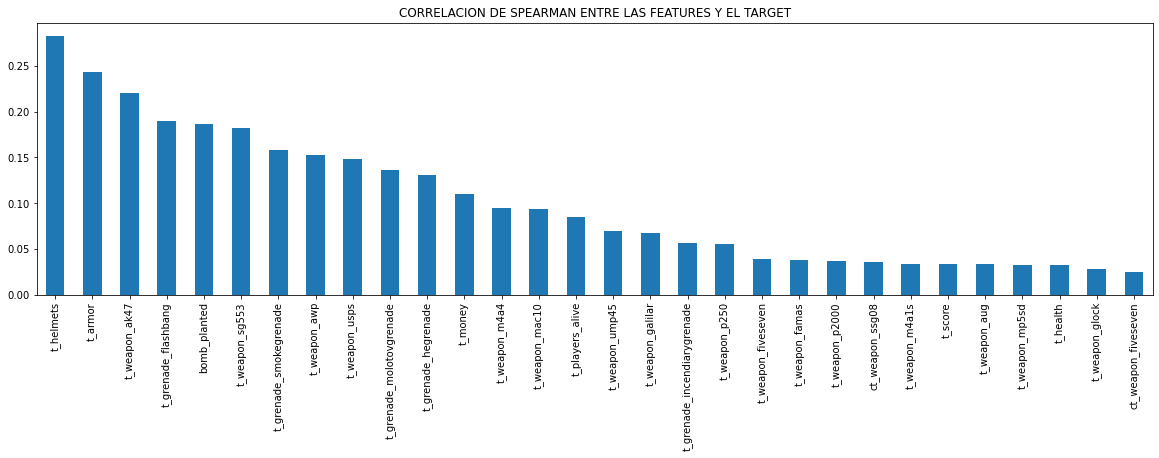

In [10]:
# Correlacion de Spearman es que cuando una feature aumenta, el valor del target aumenta 
# y viceversa, cuando el valor de una feature disminuye, el target, disminuye

features_spearman_correlation=(df.corr(method='spearman'))['round_winner'].drop(index='round_winner').sort_values(ascending = False)[:30]

features_spearman_correlation.plot(kind='bar', figsize=(20,5), title = 'CORRELACION DE SPEARMAN ENTRE LAS FEATURES Y EL TARGET')

plt.show()


In [11]:
features_con_mayor_spearman_correlation=(df.corr(method='spearman'))['round_winner'].drop(index='round_winner').sort_values(ascending = False)[:5].index

features_con_mayor_spearman_correlation=pd.concat([df[features_con_mayor_spearman_correlation], df['round_winner']], axis=1)



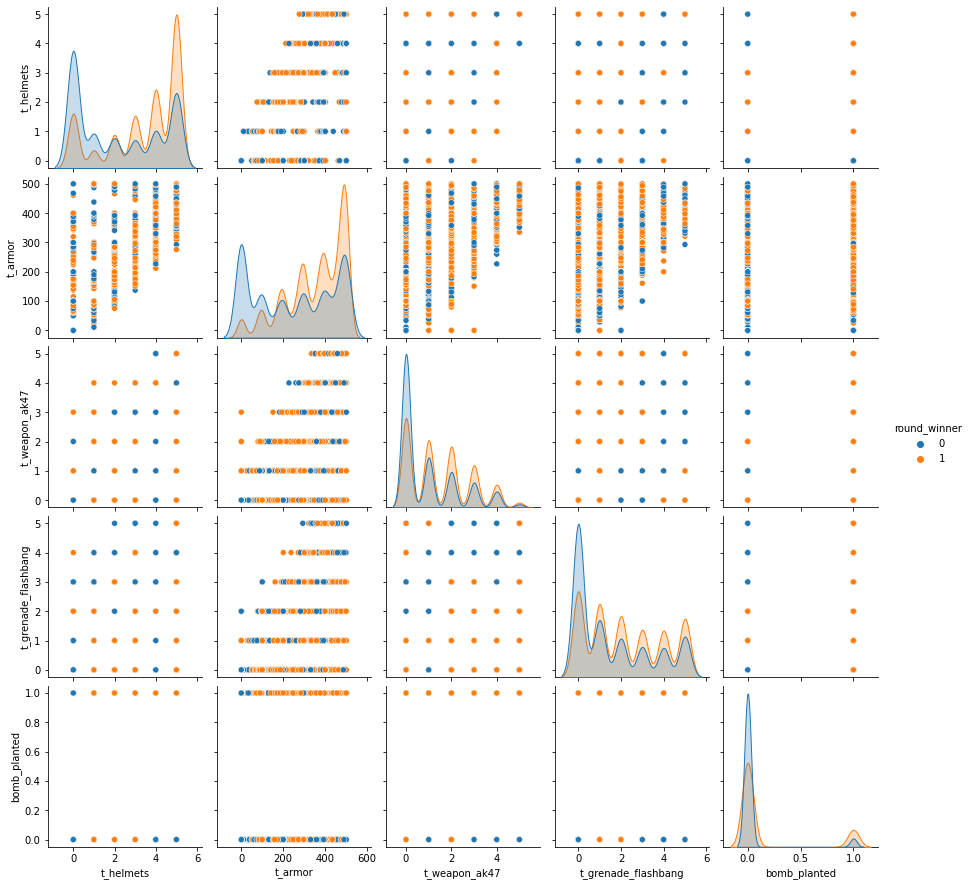

In [12]:
features_con_mayor_spearman_correlation = features_con_mayor_spearman_correlation.sample(frac=0.25, random_state = 1204)

sns.pairplot(features_con_mayor_spearman_correlation, hue = 'round_winner')

plt.show()

La compra de cascos, pareciera beneficiar mas al equipo `Terrorist` que al `Counter-Terrorist`

La compra de ct_granadas flashbang, parece ayudar bastante al equipo `Counter-Terrorist` a repeler el ataque `Terrorist`

### ESTUDIAMOS LA DISTRIBUCION DE LA VARIABLE TARGET


In [13]:
df['round_winner'].value_counts(normalize = True)

1    0.51007
0    0.48993
Name: round_winner, dtype: float64

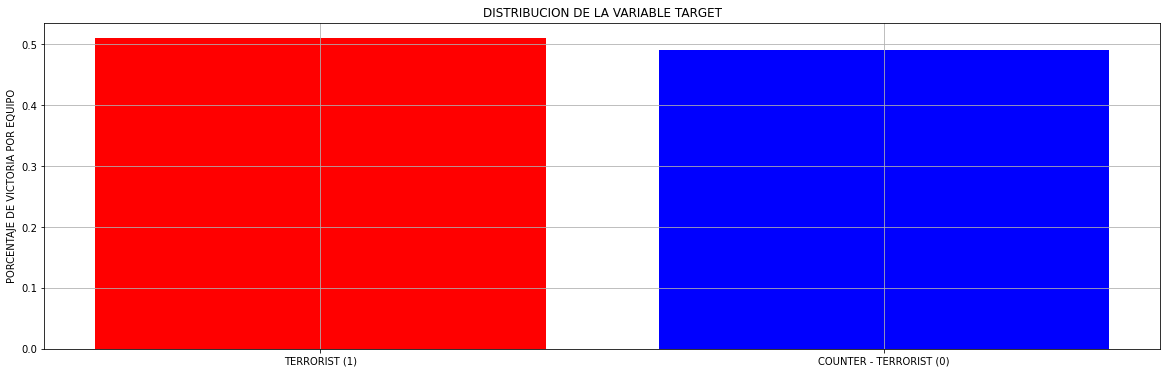

In [14]:
plt.figure(figsize=(20,6)); ax = plt.axes()
ax.bar(x= ['TERRORIST (1)', 'COUNTER - TERRORIST (0)'], height=df['round_winner'].value_counts(normalize = True), color=['r','b'])
plt.title('DISTRIBUCION DE LA VARIABLE TARGET')
plt.ylabel('PORCENTAJE DE VICTORIA POR EQUIPO')
plt.grid()

plt.show()

**Parecen estar bastante balanceados ambos lados de juego, tanto el atacante como el defensor.**

### ESTUDIAMOS QUE MAPAS FUERON UTILIZADOS Y SU RELACION CON EL TARGET

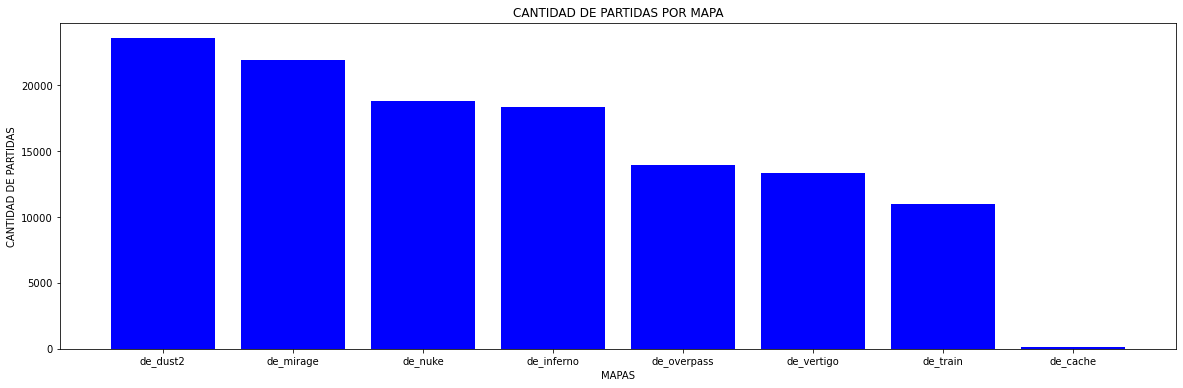

In [15]:
plt.figure(figsize=(20,6)); ax = plt.axes()
ax.bar(x= df.map.unique(),height=df.map.value_counts(), color='b')
plt.xlabel('MAPAS')
plt.ylabel('CANTIDAD DE PARTIDAS')
plt.title('CANTIDAD DE PARTIDAS POR MAPA')

plt.show()

In [16]:
mapas = df.map.unique()

ct_winrate_map=[df[df.map == mapa]['round_winner'].value_counts(normalize= True)[0] for mapa in mapas]
t_winrate_map=[df[df.map == mapa]['round_winner'].value_counts(normalize= True)[1] for mapa in mapas]

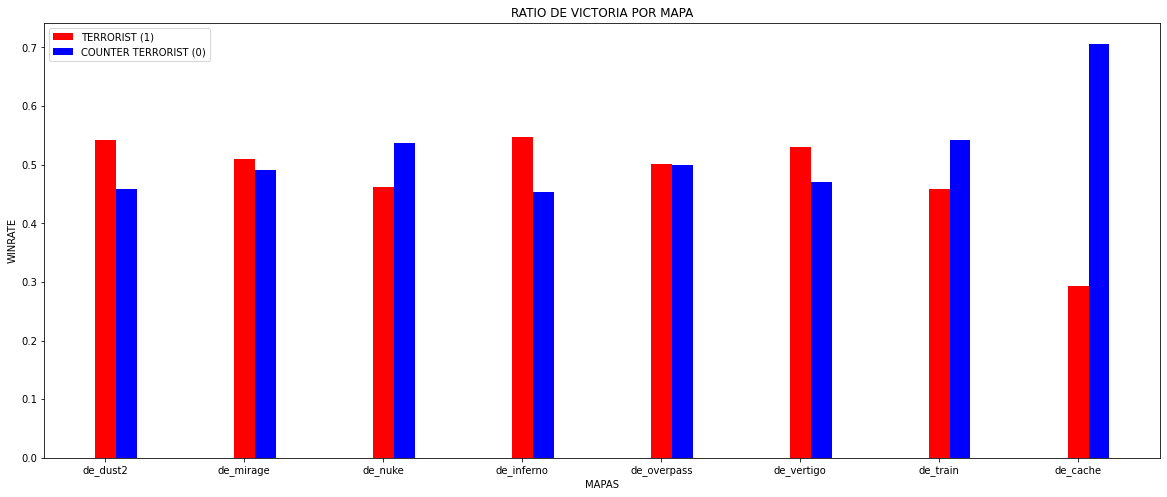

In [17]:
ind = np.arange(8) # crea la lista con numeros entre 0 y 4
width = 0.15 # ancho de las barras

fig = plt.figure(figsize=(20,8)); ax = plt.axes()
ax.bar(ind+ 0.00, t_winrate_map, width, color='r') # barra roja. 
ax.bar(ind+ 0.15, ct_winrate_map, width, color='b') # barra azul 


ax.set_title('RATIO DE VICTORIA POR MAPA')
ax.set_ylabel('WINRATE')
ax.set_xlabel('MAPAS')
ax.set_xticks(ind)
ax.set_xticklabels(mapas)
ax.legend(labels=['TERRORIST (1)', 'COUNTER TERRORIST (0)'])
# sns.set(font_scale = 1.5)
plt.show()

Vemos una gran ventaja para defender en el mapa `de_cache`, pero, fue muy poco utilizado

Vemos que estan bastante equilibrados los ratios entre ambos lados en los demas mapas

### ESTUDIAMOS LA BOMBA EN FUNCION DEL TARGET 

###### PORCENTAJE DE BOMBA PLANTADA EN LA PARTIDA

In [18]:
round(((df[df.bomb_planted==1].shape[0]/ df.shape[0])*100),2)

11.08

*Se planto la bomba en un 11% de las partidas*

In [19]:
victorias_bomba_plantada = pd.DataFrame(df.groupby('round_winner')['bomb_planted'].sum())

victorias_bomba_plantada['PORCENTAJE DE VICTORIA %'] = ((victorias_bomba_plantada['bomb_planted']/(victorias_bomba_plantada.sum()[0])*100).round(2))

victorias_bomba_plantada.rename(columns = {'bomb_planted':'VECES QUE FUE PLANTADA DE LA BOMBA'}, inplace=True)

victorias_bomba_plantada.index = ['COUNTER-TERRORIST','TERRORIST']

victorias_bomba_plantada

,VECES QUE FUE PLANTADA DE LA BOMBA,PORCENTAJE DE VICTORIA %
COUNTER-TERRORIST,3021,22.52
TERRORIST,10391,77.48


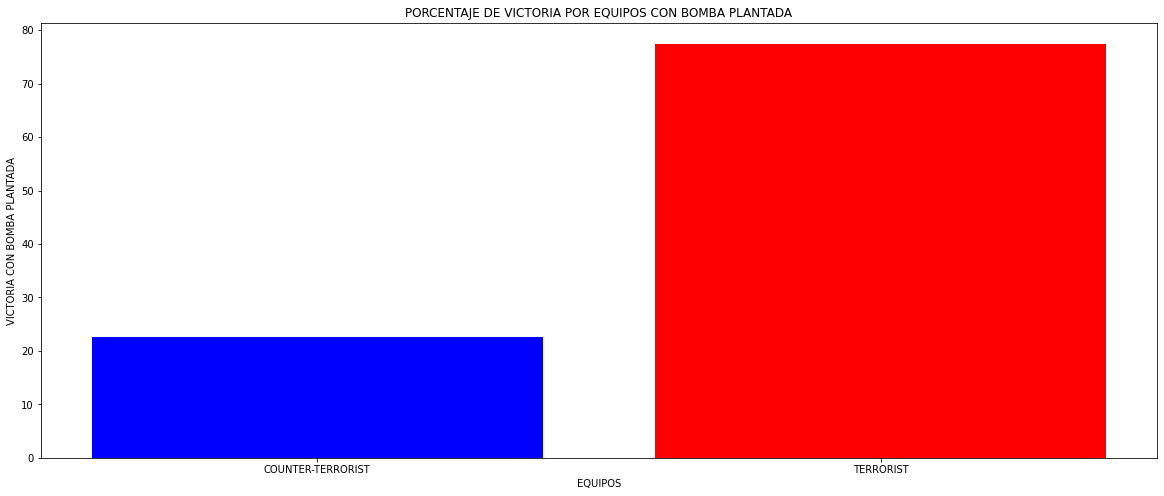

In [20]:
bomba = plt.figure(figsize=(20,8)); bomba_axes = plt.axes()

bomba_axes = plt.bar(x = victorias_bomba_plantada.index , height=victorias_bomba_plantada['PORCENTAJE DE VICTORIA %'], color = ['b','r'])

plt.xlabel('EQUIPOS')
plt.ylabel('VICTORIA CON BOMBA PLANTADA')
plt.title('PORCENTAJE DE VICTORIA POR EQUIPOS CON BOMBA PLANTADA')

plt.show()

Podemos ver una muy gran probabilidad de victoria del equipo `Terrorist` cuando logra plantar la bomba

In [21]:
# Primero separo en X e y(variable target)

X = df.drop('round_winner', axis=1)
y = df.round_winner

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=1203)

In [22]:
class MakeDummies(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = pd.get_dummies(X, columns = self.columns, drop_first = True)
        self.feature_names = X1.columns.tolist()
        return X1
    
    def get_feature_names(self):
        return self.feature_names
            
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = pd.DataFrame(X[self.features])
        self.feature_names = X1.columns.tolist()
        return pd.DataFrame(X[self.features])
    
    def get_feature_names(self):
        return self.feature_names
      
    
class MakeInt(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = pd.DataFrame(X[self.columns].astype(int))
        self.feature_names = X1.columns.tolist()
        return pd.DataFrame(X[self.columns].astype(int))
    
    def get_feature_names(self):
        return self.feature_names
    
    
    

#### DUMMIES PIPELINE

In [23]:
dummies_pipe = make_pipeline(FeatureSelector(['map']),
                             MakeDummies(['map']))

dummies_pipe.fit_transform(X).sample(3)

,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
9892,0,0,1,0,0,0,0
25766,0,0,0,0,0,0,1
110945,0,0,0,1,0,0,0


In [24]:
dummies_pipe[1].get_feature_names()

['map_de_dust2',
 'map_de_inferno',
 'map_de_mirage',
 'map_de_nuke',
 'map_de_overpass',
 'map_de_train',
 'map_de_vertigo']

#### INT PIPELINE

In [25]:
int_pipeline = make_pipeline(FeatureSelector(['bomb_planted']),
                             MakeInt(['bomb_planted']))

In [26]:
int_pipeline.fit_transform(X).head(3)

,bomb_planted
0,0
1,0
2,0


In [27]:
int_pipeline[1].get_feature_names()

['bomb_planted']

#### RESTO DE COLUMNAS

In [28]:
resto_de_columnas = (X.drop(['bomb_planted','map'], axis=1)).columns


resto_de_columnas_pipeline = make_pipeline(FeatureSelector(resto_de_columnas)) 

resto_de_columnas_pipeline.fit_transform(X).head(3)

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,175.00,0.0,0.0,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,156.03,0.0,0.0,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.03,0.0,0.0,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# resto_de_columnas_pipeline[0]

In [30]:
# resto_de_columnas_pipeline

In [31]:
resto_de_columnas_pipeline[0].get_feature_names()[:10]

['time_left',
 'ct_score',
 't_score',
 'ct_health',
 't_health',
 'ct_armor',
 't_armor',
 'ct_money',
 't_money',
 'ct_helmets']

#### UNION

In [32]:
union = make_union(dummies_pipe, 
                   int_pipeline,
                   resto_de_columnas_pipeline)

In [33]:
union

FeatureUnion(transformer_list=[('pipeline-1',
                                Pipeline(steps=[('featureselector',
                                                 FeatureSelector(features=['map'])),
                                                ('makedummies',
                                                 MakeDummies(columns=['map']))])),
                               ('pipeline-2',
                                Pipeline(steps=[('featureselector',
                                                 FeatureSelector(features=['bomb_planted'])),
                                                ('makeint',
                                                 MakeInt(columns=['bomb_planted']))])),
                               ('pipeline-3',
                                Pipeline(steps=[('featureselect...
       't_weapon_p2000', 'ct_weapon_tec9', 't_weapon_tec9',
       'ct_grenade_hegrenade', 't_grenade_hegrenade', 'ct_grenade_flashbang',
       't_grenade_flashbang', 'ct_grenade_smoke

In [55]:
# Aplico la union de transformaciones a X_train

union.fit_transform(X_train)

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 4., 0., 0.]])

In [35]:
# union.transformer_list

In [36]:
# union.transformer_list[2][1][0]

In [37]:
# Obtengo los nombres de todas mis features explicativas, para luego poder utilizarlas

columnas = []
for i in range (len(union.transformer_list)):
    list = union.transformer_list[i][-1][-1].get_feature_names()
    for element in list:
        columnas.append(element)

print(columnas[:10])    

['map_de_dust2', 'map_de_inferno', 'map_de_mirage', 'map_de_nuke', 'map_de_overpass', 'map_de_train', 'map_de_vertigo', 'bomb_planted', 'time_left', 'ct_score']


## INSTANCIAMOS UN CLASIFICADOR BASELINE

In [39]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

accuracy_score(y_test, dc.predict(X_test))

0.5100779804388051

###### **Nuestro dataset dio un baseline del 51%**

## CREAMOS NUESTRO MODELO

In [40]:
# steps_modelo = [ ('feature_eng', union),
#                  ('estandarizacion', StandardScaler()),
#                  ('estimador', CatBoostClassifier())]

In [41]:
steps_modelo = [('feature_eng', union),
                ('estandarizacion', StandardScaler()),
                ('estimador', LGBMClassifier(importance_type='gain'))]



In [42]:
pipe_modelo = Pipeline(steps_modelo)

In [43]:
pipe_modelo.fit(X_train, y_train)

Pipeline(steps=[('feature_eng',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureselector',
                                                                  FeatureSelector(features=['map'])),
                                                                 ('makedummies',
                                                                  MakeDummies(columns=['map']))])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('featureselector',
                                                                  FeatureSelector(features=['bomb_planted'])),
                                                                 ('makeint',
                                                                  MakeInt(columns=['bomb_planted']))])),
                                                ('pipeline-3',...
       't_grenade_flashbang', 

In [77]:
# Accuracy del modelo, sin usar gridsearch

display('Accuracy del modelo sin GridSearch',accuracy_score(y_test, pipe_modelo.predict(X_test)),
        'f1_score del modelo sin GridSearchcv', f1_score(y_test, pipe_modelo.predict(X_test)))

'Accuracy del modelo sin GridSearch'

0.7779870473169442

'f1_score del modelo sin GridSearchcv'

0.7733054421539188

In [57]:
# Ahora vamos a utilizar GridSearch para tunear nuestro modelo

param_grid = [{'estandarizacion':[StandardScaler(), MinMaxScaler()],
               'estimador__learning_rate':[0.2], #[np.linspace(0.01,0.3,5)]
               'estimador__n_estimators':[4000] #[np.linspace(3000,4000,2)]
               }]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1203)

gs = GridSearchCV(pipe_modelo, param_grid, n_jobs=-1, cv= skf, scoring='f1')

In [58]:
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1203, shuffle=True),
             estimator=Pipeline(steps=[('feature_eng',
                                        FeatureUnion(transformer_list=[('pipeline-1',
                                                                        Pipeline(steps=[('featureselector',
                                                                                         FeatureSelector(features=['map'])),
                                                                                        ('makedummies',
                                                                                         MakeDummies(columns=['map']))])),
                                                                       ('pipeline-2',
                                                                        Pipeline(steps=[('featureselector',
                                                                                         FeatureSelector(featur...
       't_gr

In [59]:
gs.best_params_

{'estandarizacion': StandardScaler(),
 'estimador__learning_rate': 0.2,
 'estimador__n_estimators': 4000}

In [60]:
best_model = gs.best_estimator_

In [62]:

f1_score(y_test, best_model.predict(X_test))

0.9084642148733458

## METRICAS

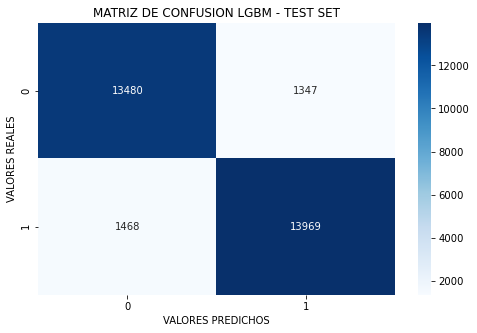

In [89]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test,best_model.predict(X_test)), annot=True, fmt='4d',cmap='Blues')
plt.xlabel('VALORES PREDICHOS')
plt.ylabel('VALORES REALES')
plt.title('MATRIZ DE CONFUSION LGBM - TEST SET')
plt.show()


In [51]:
print(classification_report(y_test,best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     14827
           1       0.91      0.90      0.91     15437

    accuracy                           0.91     30264
   macro avg       0.91      0.91      0.91     30264
weighted avg       0.91      0.91      0.91     30264



In [52]:

roc_auc_score(y_test,best_model.predict(X_test))

0.9070280124247351

**Podemos observar que nuestro modelo esta performando bastante bien, para clasificar las victorias del equipo atacante (Terrorist)**

## FEATURE IMPORTANCES

In [53]:
feature_names = columnas
feature_importances = best_model[2].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importances': feature_importances})

importance_sorted =importance.sort_values('feature_importances', ascending = False).head(6)

importance_sorted

,feature_names,feature_importance
13,ct_armor,60961.146003
14,t_armor,45229.176425
15,ct_money,24418.813595
16,t_money,23867.756560
8,time_left,15319.463501
10,t_score,14461.338653


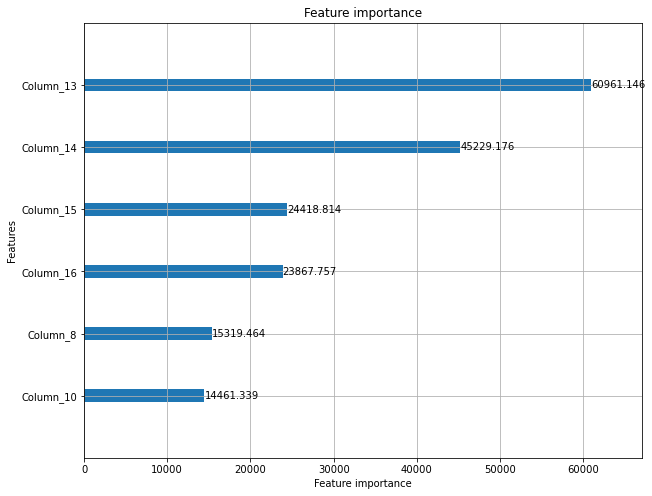

In [56]:
plot_importance(best_model[2], figsize =(10,8), max_num_features=6)
plt.show()

# CONCLUSIONES **`REVISAAAAAAAAR!!!`**:

Observamos que la variable que mas influye en la victoria del equipo atacante es la `armadura o chaleco kevlar`, donde, impacta mas en la victoria del equipo atacante, que el equipo defensor no haya podido comprar bien su armadura, a que el equipo defensor lo haga. Esto se debe probablemente a que al momento de atacar se desarrolla una situacion de mayoria numerica del lado atacante frente al defensor, con lo cual, la armadura o chaleco kevlar, cobra mucha relevancia en ésta situacion.

El siguiente atributo que cobra importancia es el `dinero`, tanto como que el equipo atacante tenga una buena economia para equiparse correctamente, asi como tambien que el equipo defensor tenga una mala economia (la diferencia entre estos dos atributos es del 2%).**Ésto nos indica que la mejor estrategia es, mantener una economia sana, y a la vez atacar la economia del equipo defensor, en rondas "economicas", por ejemplo, o en situaciones de 1 vs 4, donde la derrota de la ronda es bastante probable, se puede mejorar las chances de victoria en rondas siguientes, atacando la economia rival**

El siguiente factor que vemos en orden de importancia, es el `tiempo de ronda`.


El siguiente factor que vemos en orden de importancia, es el `score`. Existen 

.Podemos verlo como "NUNCA ALGO ESTA GANADO", scores altos, generan confianza y descuido en los jugadores, incluso en los rangos profesionales, con lo cual, estos descuidos, generan derrotas, que generan perdidas economicas para el equipo y pueden desembocar en una recuperacion del equipo enemigo.**Esto nos indica que debemos mantener la concentracion ignorando el score y la diferencia entre ambos equipos**.



FALTA...

1) Ver pq m4_ct es mas efectiva para que ganenn los terrors, que la ak47.


### **ESTUDIAMOS QUE FEATURES FAVORECEN AL EQUIPO ATACANTE DISCRIMINANDO POR MAPA**

In [ ]:
df_de_dust2 =    df_combinacion.drop(['de_inferno','de_mirage','de_nuke','de_overpass', 'de_train','de_vertigo','de_cache'], axis=1)
df_de_mirage =   df_combinacion.drop(['de_inferno','de_dust2','de_nuke','de_overpass', 'de_train','de_vertigo','de_cache'], axis=1)
df_de_nuke =     df_combinacion.drop(['de_inferno','de_dust2','de_mirage','de_overpass', 'de_train','de_vertigo','de_cache'], axis=1)
df_de_inferno =  df_combinacion.drop(['de_mirage','de_dust2','de_nuke','de_overpass', 'de_train','de_vertigo','de_cache'], axis=1)
df_de_overpass = df_combinacion.drop(['de_inferno','de_dust2','de_nuke','de_mirage', 'de_train','de_vertigo','de_cache'], axis=1)
df_de_vertigo =  df_combinacion.drop(['de_inferno','de_dust2','de_nuke','de_overpass', 'de_train','de_mirage','de_cache'], axis=1)
df_de_train =    df_combinacion.drop(['de_inferno','de_dust2','de_nuke','de_overpass', 'de_mirage','de_vertigo','de_cache'], axis=1)
df_de_cache =    df_combinacion.drop(['de_inferno','de_dust2','de_nuke','de_overpass', 'de_train','de_vertigo','de_mirage'], axis=1)


# DE_DUST2

In [ ]:
X_train_de_dust2, X_test_de_dust2, y_train_de_dust2, y_test_de_dust2 = \
train_test_split(df_de_dust2, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_dust2=best_model.fit(X_train_de_dust2, y_train_de_dust2)

In [ ]:
feature_names = df_de_dust2.columns
feature_importance = model_de_dust2[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

In [ ]:
plot_importance(model_de_dust2[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_MIRAGE

In [ ]:
X_train_de_mirage, X_test_de_mirage, y_train_de_mirage, y_test_de_mirage = \
train_test_split(df_de_mirage, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_mirage=best_model.fit(X_train_de_mirage, y_train_de_mirage)

In [ ]:
feature_names = df_de_mirage.columns
feature_importance = model_de_mirage[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

In [ ]:
plot_importance(model_de_mirage[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_NUKE

In [ ]:
X_train_de_nuke, X_test_de_nuke, y_train_de_nuke, y_test_de_nuke = \
train_test_split(df_de_mirage, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_nuke=best_model.fit(X_train_de_nuke, y_train_de_nuke)

In [ ]:
feature_names = df_de_nuke.columns
feature_importance = model_de_nuke[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

In [ ]:
plot_importance(model_de_nuke[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_INFERNO

In [ ]:
X_train_de_inferno, X_test_de_inferno, y_train_de_inferno, y_test_de_inferno = \
train_test_split(df_de_inferno, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_inferno=best_model.fit(X_train_de_inferno, y_train_de_inferno)

In [ ]:
feature_names = df_de_inferno.columns
feature_importance = model_de_inferno[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

In [ ]:
plot_importance(model_de_inferno[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_OVERPASS

In [ ]:
X_train_de_overpass, X_test_de_overpass, y_train_de_overpass, y_test_de_overpass = \
train_test_split(df_de_overpass, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_overpass=best_model.fit(X_train_de_overpass, y_train_de_overpass)

In [ ]:
feature_names = df_de_overpass.columns
feature_importance = model_de_overpass[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

In [ ]:
plot_importance(model_de_overpass[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_VERTIGO

In [ ]:
X_train_de_vertigo, X_test_de_vertigo, y_train_de_vertigo, y_test_de_vertigo = \
train_test_split(df_de_vertigo, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_vertigo=best_model.fit(X_train_de_vertigo, y_train_de_vertigo)

In [ ]:
feature_names = df_de_vertigo.columns
feature_importance = model_de_vertigo[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

In [ ]:
plot_importance(model_de_vertigo[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_TRAIN

In [ ]:
X_train_de_train, X_test_de_train, y_train_de_train, y_test_de_train = \
train_test_split(df_de_train, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_train=best_model.fit(X_train_de_train, y_train_de_train)

In [ ]:
feature_names = df_de_train.columns
feature_importance = model_de_train[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

In [ ]:
plot_importance(model_de_train[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_CACHE

In [ ]:
X_train_de_cache, X_test_de_cache, y_train_de_cache, y_test_de_cache = \
train_test_split(df_de_cache, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_cache=best_model.fit(X_train_de_cache, y_train_de_cache)

In [ ]:
feature_names = df_de_cache.columns
feature_importance = model_de_cache[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

In [ ]:
plot_importance(model_de_cache[1], figsize =(10,8), max_num_features=12)
plt.show()

Podemos concluir que **NO HAY** variaciones significativas en las feature importance **EN FUNCION DEL MAPA**

## ANALISIS CON LIME

In [ ]:
X_train.head()

In [ ]:
categorical = np.arange(0,9)

explainer = LimeTabularExplainer(np.array(X_train), 
                                 mode = "classification",
                                 training_labels = y_train,
                                 feature_names = feature_names, 
                                 categorical_features  = categorical,
                                 discretize_continuous=True, 
                                 discretizer = 'decile')

In [ ]:
data_row = np.array(X_test.iloc[2]) # prueba con cualquier valor

explanation = explainer.explain_instance(data_row, best_model[1].predict_proba, num_features=5)



In [ ]:
explanation.show_in_notebook(show_table=True)

In [ ]:
explanation.as_pyplot_figure()

In [ ]:
A = pd.DataFrame({'VERDADEROS_VALORES':y_test.values,
                  'VALORES_PREDICHOS':best_model.predict(X_test),
                  'ERRORES':y_test.values!=best_model.predict(X_test)}
                )
A.sample(5)